# Übungsblatt 4: MCMC

 * [Aufgabe 1](#Aufgabe-1)
 * [Aufgabe 2](#Aufgabe-2)
 
---

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from functools import partial

plt.style.use('ggplot')

---
## Aufgabe 1
Erzeugen Sie Paare von Zufallszahlen (x, y) die gemäß der zweidimensionalen Dichte

\begin{equation}
    f(x, y) \propto \exp\left(-((x-2)x + y^2)/10\right)\cdot\sin^2(x\cdot y + x)
\end{equation}

verteilt sind. Bestimmen Sie daraus die Verteilung $\rho(r)$ mit $r = x^2 + y^2$.

---

In [2]:
def mcmc_step(pdf, xs):
    ds = np.random.uniform(-3, 3, size=len(xs))
    r = np.random.uniform()
    nxs = xs + ds
    p0 = pdf(xs)
    p1 = pdf(nxs)
    if p1 > p0 or r < (p1 / p0):
        return nxs
    return xs


def mcmc_burnin(pdf, xs, steps=10000):
    for _ in range(steps):
        xs = mcmc_step(pdf, xs)
    return xs


def mcmc_sample(pdf, xs, steps=100000):
    xss = []
    for _ in range(steps):
        xs = mcmc_step(pdf, xs)
        xss.append(xs)
    return np.array(xss).T


def pdf(xs):
    x, y = xs
    return np.exp(-((x - 2) * x + y ** 2) / 10) * np.sin(x * y + x) ** 2


xs = mcmc_burnin(pdf, np.array([0, 0]))
xs, ys = mcmc_sample(pdf, xs)

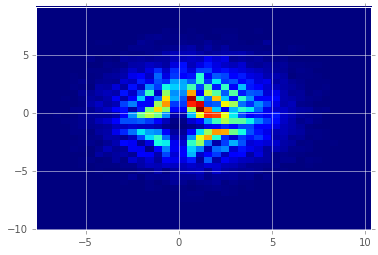

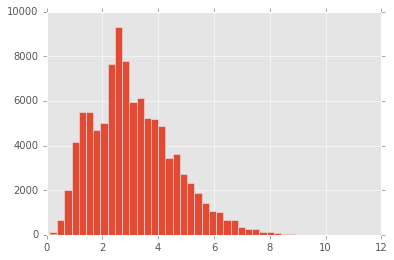

In [3]:
plt.hist2d(xs, ys, bins=40)
plt.show()

plt.hist(np.sqrt(xs ** 2 + ys ** 2), bins=40)
plt.show()

---
## Aufgabe 2
Ein Experiment beobachtet $n$ Ereignisse. Die Nachweiswahrscheinlichkeit für ein Ereignis sei $ε$. Die wahre Anzahl ist Poisson-verteilt mit einem Mittelwert $μ$, der eine Funktion zweier Theorieparameter $a$ und $b$ ist, $μ = a^b$. Aus Kalibrationsmessungen ist bekannt dass $ε$ Gauss-verteilt ist mit $ε = 0.75 \pm 0.05$. Vom Parameter $b$ ist bekannt dass er nahe bei $b = 1$ liegt. Für ihn wird eine gleichförmige Verteilung im Bereich $0.9 < b < 1.1$ angenommen. Der Parameter $a$ muss positiv sein. Verwenden Sie bayes’sche Statistik und MCMC, und bestimmen Sie für $n = 1$ und $n = 10$ die posterior Verteilung von $a$ nach Integration über die Nuissance-Parameter $ε$ und $b$.

---

Es ist

\begin{align}
    p(a\,|\,n, \varepsilon, b) &= \mathrm{Poisson}(n, \varepsilon\mu) \\
                               &= \mathrm{Poisson}(n, \varepsilon a^b) \cdot \mathrm{Uniform}(b, 0.9, 1.1) \cdot \mathrm{Gauß}(\varepsilon, 0.75, 0.05)
\end{align}

Dieser Ausdruck wird jetzt per MCMC über $\varepsilon$ und $b$ integriert um die Verteilung von $p(a\,|\,n)$ zu erhalten. Zunächst definieren wir die Funktion $p = p(a\,|\,n, eps, b)$.

In [4]:
uniform_b = scipy.stats.uniform(0.9, 1.1).pdf
gaussian_eps = scipy.stats.norm(0.75, 0.05).pdf

def p(a, n, eps, b):
    if a <= 0:
        return 0
    epsab = eps * a**b
    return scipy.stats.poisson.pmf(n, epsab) * uniform_b(b) * gaussian_eps(eps)

Diese können wir dann bequem mit unseren, in Aufgabe 1 formulierten, MCMC-Funktionen verwenden. Wir müssen uns nur einen kleinen Wrapper schreiben.

In [5]:
def p_n(n, pars):
    a, eps, b = pars
    return p(a, n, eps, b)


p_1 = partial(p_n, 1)
xs = mcmc_burnin(p_1, np.array([0.01, 0.75, 1]))
as1, _, _ = mcmc_sample(p_1, xs)


p_10 = partial(p_n, 10)
xs = mcmc_burnin(p_10, np.array([0.01, 0.75, 1]))
as10, _, _ = mcmc_sample(p_10, xs)

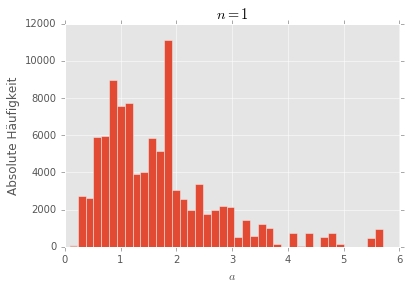

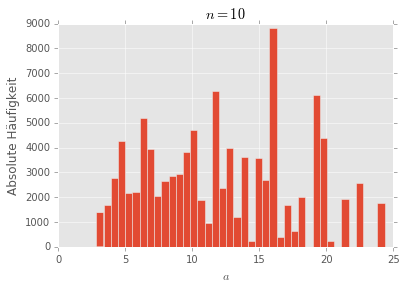

In [6]:
plt.hist(as1, bins=40)
plt.title('$n = 1$')
plt.xlabel('$a$')
plt.ylabel('Absolute Häufigkeit')
plt.show()

plt.hist(as10, bins=40)
plt.title('$n = 10$')
plt.xlabel('$a$')
plt.ylabel('Absolute Häufigkeit')
plt.show()